In [ ]:
!pip install roboflow -q
!pip install pycocotools -q
!pip install torchmetrics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/5

In [ ]:
import os
import json
import numpy as np

import matplotlib.pyplot as plt
from pycocotools.coco import COCO

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
BASE_DIR = "/content"

In [ ]:
from roboflow import Roboflow
from google.colab import userdata

apiKey = userdata.get('roboflowKey')
rf = Roboflow(api_key=apiKey)
project = rf.workspace("wyhil-ru2ds").project("workers-safety-equipment-z1mra")
version = project.version(3)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to workers-safety-equipment-3 in coco:: 100%|██████████| 1435/1435 [00:00<00:00, 3014.98it/s]


In [ ]:
DATASET_PATH = os.path.join(BASE_DIR, 'dataset')
# Assuming 'dataset' is the folder downloaded by roboflow
!cp -r {dataset.location} {DATASET_PATH}
print(f"Dataset saved to: {DATASET_PATH}")

Dataset saved to: /content/dataset


In [ ]:
TRAIN_IMAGE_DIR = os.path.join(DATASET_PATH, "train")
TRAIN_ANNOTATION_FILE = os.path.join(DATASET_PATH, "train", "_annotations.coco.json")

VAL_IMAGE_DIR = os.path.join(DATASET_PATH, "valid")
VAL_ANNOTATION_FILE = os.path.join(DATASET_PATH, "valid", "_annotations.coco.json")

TEST_IMAGE_DIR = os.path.join(DATASET_PATH, "test")
TEST_ANNOTATION_FILE = os.path.join(DATASET_PATH, "test", "_annotations.coco.json")

In [ ]:
from tqdm import tqdm
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.datasets import CocoDetection
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision import transforms
from torchvision.transforms import functional as F

In [ ]:
class_labels = {
    1: 'Gloves',
    2: 'Helmet',
    3: 'Non-Helmet',
    4: 'Person',
    5: 'Shoes',
    6: 'Vest',
    7: 'bare-arms'
}

NUM_CLASSES = len(class_labels) + 1

In [ ]:
class ComposeWithTarget:
    def __init__(self, transforms):
        self.transforms = transforms
    def __call__(self, img, targets):
        for transform in self.transforms:
            img = transform(img)
        return img, targets

transform = ComposeWithTarget([
    transforms.ToTensor()
])

In [ ]:
train_ds_coco = CocoDetection(
    root=TRAIN_IMAGE_DIR,
    annFile=TRAIN_ANNOTATION_FILE,
    transforms=transform
)
print(f"Number of training images: {len(train_ds_coco)}")
val_ds_coco = CocoDetection(
    root=VAL_IMAGE_DIR,
    annFile=VAL_ANNOTATION_FILE,
    transforms=transform
)
print(f"Number of validating images: {len(val_ds_coco)}")
test_ds_coco = CocoDetection(
    root=TEST_IMAGE_DIR,
    annFile=TEST_ANNOTATION_FILE,
    transforms=transform
)
print(f"Number of testing images: {len(test_ds_coco)}")

loading annotations into memory...
Done (t=0.20s)
creating index...
index created!
Number of training images: 999
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of validating images: 286
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of testing images: 142


In [ ]:
class SafetyEquipmentCoco(torch.utils.data.Dataset):
    def __init__(self, coco, resized_size=224):
        self.coco = coco
        self.resized_size = resized_size

    def __len__(self):
        return len(self.coco)

    def __getitem__(self, idx):
        img, targets = self.coco[idx]

        # get resized scale & resize image
        if isinstance(img, torch.Tensor):
            _, orig_h, orig_w = img.shape
        else:
            orig_w, orig_h = img.size
        scale_w = self.resized_size / orig_w
        scale_h = self.resized_size / orig_h
        img = F.resize(img, [self.resized_size, self.resized_size])

        # resize bounding boxes
        boxes, labels = [], []
        for target in targets:
            x, y, w, h = target['bbox']
            x1 = x * scale_w
            y1 = y * scale_h
            x2 = (x + w) * scale_w
            y2 = (y + h) * scale_h
            boxes.append([x1, y1, x2, y2])
            labels.append(target['category_id'])

        target = {
            'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor(labels)
        }
        return img, target

In [ ]:
train_dataset = SafetyEquipmentCoco(train_ds_coco, 224)
val_dataset = SafetyEquipmentCoco(val_ds_coco, 224)
test_dataset = SafetyEquipmentCoco(test_ds_coco, 224)

In [ ]:
def collate_fn(batch):
  return tuple(zip(*batch))

train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=10, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=10, collate_fn=collate_fn)

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
  model.train() # train mode

  running_train_loss = 0.0
  running_train_map = MeanAveragePrecision()

  tqdm_bar = tqdm(data_loader, total=len(data_loader))

  for idx, data in enumerate(tqdm_bar):
    images, targets = data

    # Move images and targets to the specified device
    images = [image.to(device) for image in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    loss_dict = model(images, targets)
    loss = sum(loss for loss in loss_dict.values())

    loss.backward()
    optimizer.step()
    running_train_loss += loss.item()

    model.eval() # eval mode
    with torch.no_grad():
      preds = model(images)
      running_train_map.update(preds, targets)

    model.train() # back to train model

    avg_batch_loss = running_train_loss / (idx + 1)

    tqdm_bar.set_description(desc=f"Train Loss: {avg_batch_loss:.4f}")

  avg_train_loss = running_train_loss / len(data_loader)
  train_map_result = running_train_map.compute()["map"].item()

  return avg_train_loss, train_map_result

In [ ]:
def evaluate(model, data_loader, device):
  model.eval() # eval mode
  running_val_loss = 0.0
  running_val_map = MeanAveragePrecision()

  tqdm_bar = tqdm(data_loader, total=len(data_loader))

  with torch.no_grad():
    for idx, data in enumerate(tqdm_bar):
      images, targets = data

      # Move images and targets to the specified device
      images = [image.to(device) for image in images]
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


      model.train() # change to train mode to get loss values

      loss_dict = model(images, targets)

      loss = sum(loss for loss in loss_dict.values())
      running_val_loss += loss.item()
      model.eval() # back to eval mode

      preds = model(images)
      running_val_map.update(preds, targets)

      avg_batch_loss = running_val_loss / (idx + 1)

      tqdm_bar.set_description(desc=f"Val Loss: {avg_batch_loss:.4f}")

  avg_val_loss = running_val_loss / len(data_loader)
  val_map_result = running_val_map.compute()["map"].item()

  return avg_val_loss, val_map_result

In [ ]:
def plot_history(history):
  train_maps = history['train_map']
  val_maps = history['val_map']
  train_losses = history['train_loss']
  val_losses = history['val_loss']
  fig, axs = plt.subplots(1, 2, figsize=(12, 5))

  epochs = range(1, len(train_losses) + 1)

  # Left subplot: mAP
  axs[0].plot(epochs, train_maps, label="Train mAP")
  axs[0].plot(epochs, val_maps, label="Val mAP")
  axs[0].set_xlabel("Epoch")
  axs[0].set_ylabel("mAP")
  axs[0].set_title("Training & Validation mAP")
  axs[0].legend()

  # Right subplot: Loss
  axs[1].plot(epochs, train_losses, label="Train Loss")
  axs[1].plot(epochs, val_losses, label="Val Loss")
  axs[1].set_xlabel("Epoch")
  axs[1].set_ylabel("Loss")
  axs[1].set_title("Training & Validation Loss")
  axs[1].legend()

  plt.show()

In [ ]:
OUTPUT_DIR = '/content/drive/MyDrive/FastRCNN_Project'

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

faster_rcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

in_features = faster_rcnn_model.roi_heads.box_predictor.cls_score.in_features
faster_rcnn_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

faster_rcnn_model.to(device)

params = [p for p in faster_rcnn_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=0.1, gamma=0.1)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 154MB/s]


In [ ]:
print("Model Summary:")
print(faster_rcnn_model)

Model Summary:
FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
        

In [ ]:
def training_loop(model, train_dataloader, val_dataloader, num_epochs, optimizer, lr_scheduler, early_stopping_patience = 5, file_name = "best_faster_rcnn.pth", enable_checkpoint = False):
  train_losses, val_losses = [], []
  train_maps, val_maps = [], []

  best_val_loss = float('inf')
  epochs_no_improve = 0

  for epoch in range(num_epochs):
    print(f"--------------Epoch {epoch + 1}-------------")

    avg_train_loss, train_map = train_one_epoch(model, optimizer, train_dataloader, device, epoch)
    train_losses.append(avg_train_loss)
    train_maps.append(train_map)

    lr_scheduler.step()

    avg_val_loss, val_map = evaluate(model, val_dataloader, device)
    val_losses.append(avg_val_loss)
    val_maps.append(val_map)

    print(f"\nTrain mAP: {(train_map * 100):.2f}% | Train Loss: {avg_train_loss:.4f} | "
          f"Val mAP: {(val_map * 100):.2f}% | Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      epochs_no_improve = 0

      file_path = os.path.join(OUTPUT_DIR, file_name)
      torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'train_loss': avg_train_loss,
          'val_loss': avg_val_loss
      }, file_path)
      print(f"Model saved to {file_path}")
    else:
      epochs_no_improve += 1
      if epochs_no_improve >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch + 1} due to no improvement in val loss.")
        break

    if enable_checkpoint:
      ckpt_file_name = f"model_epoch_{epoch}.pth"
      ckpt_file_path = os.path.join(OUTPUT_DIR, ckpt_file_name)
      torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'train_loss': avg_train_loss,
          'val_loss': avg_val_loss
      }, ckpt_file_path)

  history = {
      'train_loss': train_losses,
      'val_loss': val_losses,
      'train_map': train_maps,
      'val_map': val_maps
  }

  print("Training completed. Clearing cache...")
  torch.cuda.empty_cache()
  return history

In [ ]:
history = training_loop(
    model=faster_rcnn_model,
    train_dataloader = train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=7,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    early_stopping_patience = 3,
    file_name = "best_faster_rcnn.pth"
)

--------------Epoch 1-------------


Val Loss: 0.6024: 100%|██████████| 29/29 [00:51<00:00,  1.78s/it]



Train mAP: 29.82% | Train Loss: 0.9067 | Val mAP: 47.37% | Val Loss: 0.6024
Model saved to /content/drive/MyDrive/FastRCNN_Project/best_faster_rcnn.pth
--------------Epoch 2-------------


Val Loss: 0.5603: 100%|██████████| 29/29 [00:51<00:00,  1.78s/it]



Train mAP: 55.75% | Train Loss: 0.4827 | Val mAP: 54.20% | Val Loss: 0.5603
Model saved to /content/drive/MyDrive/FastRCNN_Project/best_faster_rcnn.pth
--------------Epoch 3-------------


Val Loss: 0.5162: 100%|██████████| 29/29 [00:52<00:00,  1.79s/it]



Train mAP: 62.43% | Train Loss: 0.3945 | Val mAP: 55.85% | Val Loss: 0.5162
Model saved to /content/drive/MyDrive/FastRCNN_Project/best_faster_rcnn.pth
--------------Epoch 4-------------


Val Loss: 0.5258: 100%|██████████| 29/29 [00:51<00:00,  1.77s/it]



Train mAP: 66.10% | Train Loss: 0.3423 | Val mAP: 56.57% | Val Loss: 0.5258
--------------Epoch 5-------------


Val Loss: 0.5041: 100%|██████████| 29/29 [00:51<00:00,  1.78s/it]



Train mAP: 69.32% | Train Loss: 0.3023 | Val mAP: 57.53% | Val Loss: 0.5041
Model saved to /content/drive/MyDrive/FastRCNN_Project/best_faster_rcnn.pth
--------------Epoch 6-------------


Val Loss: 0.5440: 100%|██████████| 29/29 [00:51<00:00,  1.78s/it]



Train mAP: 71.78% | Train Loss: 0.2736 | Val mAP: 56.87% | Val Loss: 0.5440
--------------Epoch 7-------------


Val Loss: 0.5349: 100%|██████████| 29/29 [00:51<00:00,  1.78s/it]



Train mAP: 73.87% | Train Loss: 0.2544 | Val mAP: 56.63% | Val Loss: 0.5349
Training completed. Clearing cache...


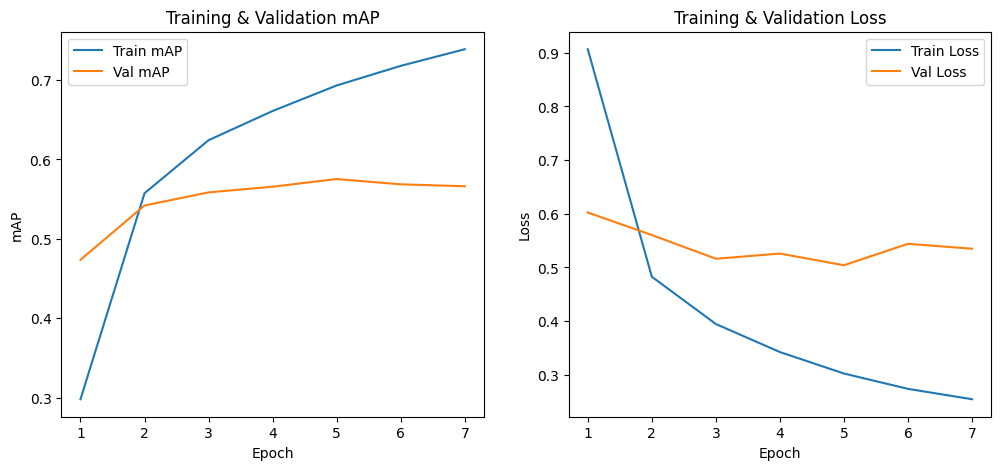

In [ ]:
plot_history(history)

In [ ]:
best_model_path = os.path.join(OUTPUT_DIR, "best_faster_rcnn.pth")

if os.path.exists(best_model_path):
  print(f"Loading model from {best_model_path}")
  checkpoint = torch.load(best_model_path, map_location=device)
  faster_rcnn_model.load_state_dict(checkpoint['model_state_dict'])
  faster_rcnn_model.to(device)
  print("Model loaded successfully.")
else:
  print(f"No best model found at {best_model_path}")


Loading model from /content/drive/MyDrive/FastRCNN_Project/best_faster_rcnn.pth
Model loaded successfully.


In [ ]:
test_losses, test_maps = evaluate(faster_rcnn_model, test_dataloader, device)
print(f"Test Loss: {test_losses:.4f} | Test mAP: {(test_maps * 100):.2f}%")

Val Loss: 0.3879: 100%|██████████| 15/15 [00:25<00:00,  1.73s/it]


Test Loss: 0.3879 | Test mAP: 68.06%


Generating Confusion Matrix: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


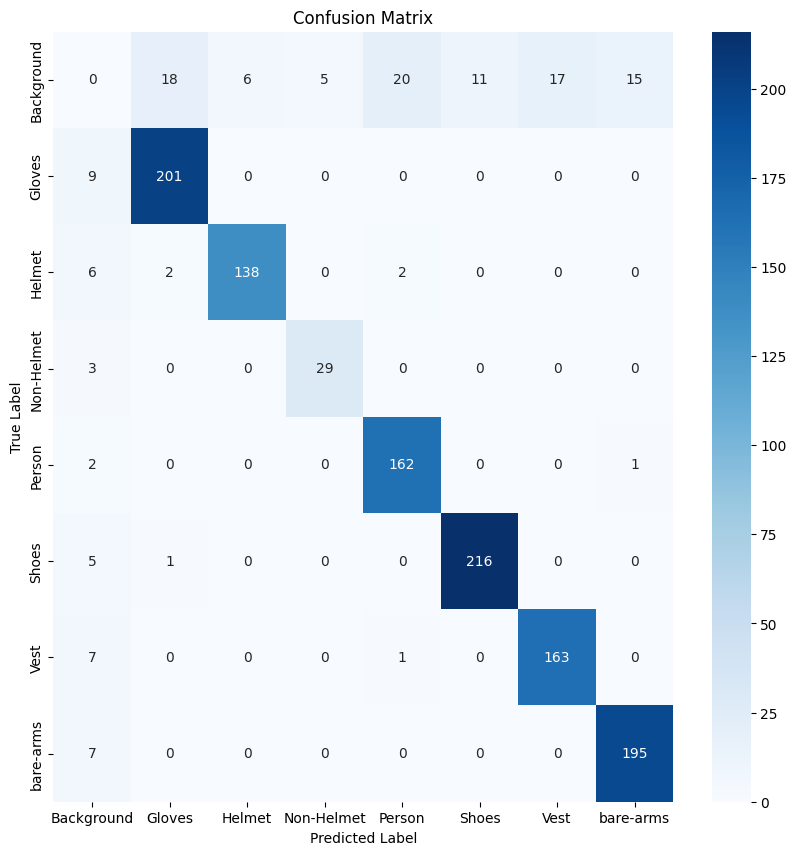

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchvision.ops import box_iou

def plot_confusion_matrix(model, data_loader, device, class_labels, threshold = 0.5, iou_threshold=0.5):
    model.eval()
    all_targets = []
    all_preds = []

    # Add a 'background' class with ID 0
    id_to_label = {0: 'Background'}
    for class_id, label in class_labels.items():
        id_to_label[class_id] = label

    # Get the unique class IDs from the dataset labels (including background 0)
    unique_class_ids = sorted(list(id_to_label.keys()))
    num_classes = len(unique_class_ids)

    # Map class IDs to a contiguous range for confusion matrix indexing
    id_to_index = {class_id: i for i, class_id in enumerate(unique_class_ids)}


    with torch.no_grad():
        for images, targets in tqdm(data_loader, total=len(data_loader), desc="Generating Confusion Matrix"):
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i in range(len(images)):
                # Get ground truth and predictions for the current image
                gt_boxes = targets[i]['boxes'].to(device)
                gt_labels = targets[i]['labels'].to(device)
                pred_boxes = outputs[i]['boxes'].to(device)
                pred_labels = outputs[i]['labels'].to(device)
                pred_scores = outputs[i]['scores'].to(device)

                keep = pred_scores > threshold
                pred_boxes = pred_boxes[keep]
                pred_labels = pred_labels[keep]

                if gt_boxes.shape[0] > 0 and pred_boxes.shape[0] > 0:
                    iou_matrix = box_iou(gt_boxes, pred_boxes)

                    # Find the best matching prediction for each ground truth box
                    # If the best IoU is below the threshold, it's a missed detection
                    matched_preds = torch.zeros(gt_boxes.shape[0], dtype=torch.long, device=device) # 0 indicates no match (missed)
                    max_iou, pred_indices = torch.max(iou_matrix, dim=1)
                    matched_mask = max_iou >= iou_threshold
                    matched_preds[matched_mask] = pred_labels[pred_indices[matched_mask]]

                    all_targets.extend(gt_labels.tolist())
                    all_preds.extend(matched_preds.tolist())

                    # Identify false positives (predicted boxes that didn't match any ground truth)
                    # A predicted box is a false positive if its best IoU with any ground truth is below the threshold
                    unmatched_preds_mask = torch.ones(pred_boxes.shape[0], dtype=torch.bool, device=device)
                    if matched_mask.any():
                        # Mark predictions that were matched to a ground truth
                        # Create a mask for the predicted boxes that were matched
                        matched_pred_indices_mask = torch.zeros(pred_boxes.shape[0], dtype=torch.bool, device=device)
                        matched_pred_indices_mask[pred_indices[matched_mask]] = True
                        unmatched_preds_mask = ~matched_pred_indices_mask

                    unmatched_pred_labels = pred_labels[unmatched_preds_mask]
                    # Treat unmatched predictions as false positives, assigning them to the background class (ID 0)
                    all_targets.extend([0] * len(unmatched_pred_labels))
                    all_preds.extend(unmatched_pred_labels.tolist())


                elif gt_boxes.shape[0] > 0:
                    # No predictions but have ground truth - all are missed detections
                    all_targets.extend(gt_labels.tolist())
                    all_preds.extend([0] * gt_boxes.shape[0]) # Assign to background class

                elif pred_boxes.shape[0] > 0:
                    # No ground truth but have predictions - all are false positives
                    all_targets.extend([0] * pred_boxes.shape[0]) # Assign to background class
                    all_preds.extend(pred_labels.tolist())


    # Convert original IDs to the indices used for the confusion matrix
    mapped_targets = [id_to_index.get(label, 0) for label in all_targets]
    mapped_preds = [id_to_index.get(label, 0) for label in all_preds]

    # Generate the confusion matrix
    cm_labels = list(range(num_classes)) # 0 to num_classes-1
    cm = confusion_matrix(mapped_targets, mapped_preds, labels=cm_labels)


    # Prepare labels for the plot (including 'Background' for class 0)
    plot_labels = [id_to_label[i] for i in unique_class_ids]

    # Plot the confusion matrix
    plt.figure(figsize=(len(plot_labels) + 2, len(plot_labels) + 2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=plot_labels, yticklabels=plot_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


plot_confusion_matrix(faster_rcnn_model, test_dataloader, device, class_labels, threshold=0.7)

In [ ]:
import matplotlib.patches as patches

def plot_image_with_boxes(ax, image_tensor, boxes, labels, scores=None, title=""):
    img = image_tensor.cpu().float()
    if img.min() < 0 or img.max() > 1:  # likely normalized
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")

    # Draw boxes
    for idx, (box, label) in enumerate(zip(boxes, labels)):
        x1, y1, x2, y2 = box
        w = x2 - x1
        h = y2 - y1
        rect = patches.Rectangle(
            (x1, y1), w, h,
            linewidth=1, edgecolor='r', facecolor='none'
        )
        label_text = f"{class_labels[label.item()]}"
        if scores is not None:
            score = scores[idx]
            label_text += f" {score:.2f}"
        ax.add_patch(rect)
        ax.text(
            x1, y1, label_text,
            color='yellow', fontsize=8,
            bbox=dict(facecolor='black', alpha=0.5)
        )

In [ ]:
def predict(model, image, device):
  model.eval()
  with torch.no_grad():
    images = [image.to(device)]
    preds = model(images)

  return {k: v.cpu() for k, v in preds[0].items()}

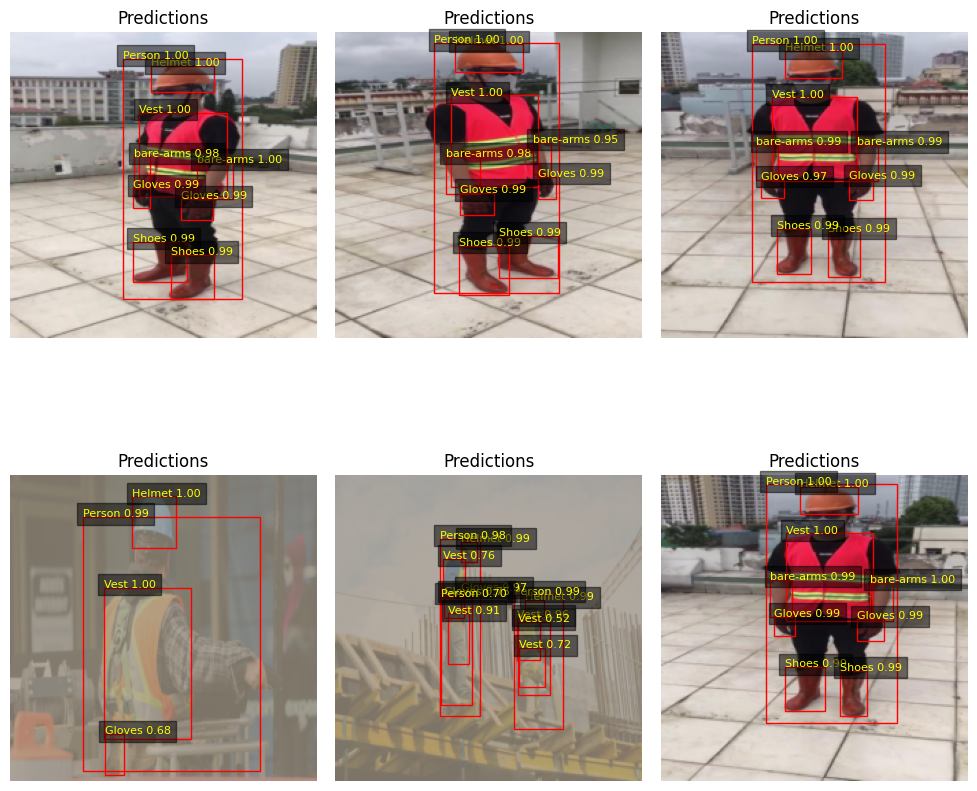

In [ ]:
import random

NUM_TO_DISPLAY = 6

all_test_images = []
all_test_targets = []

for images_batch, targets_batch in test_dataloader:
    all_test_images.extend(images_batch)
    all_test_targets.extend(targets_batch)

random_seed = 73
random.seed(random_seed)

random_indices = random.sample(range(len(all_test_images)), NUM_TO_DISPLAY)
images_list = [all_test_images[i] for i in random_indices]
targets_list = [all_test_targets[i] for i in random_indices]

preds_list = [predict(faster_rcnn_model, img, device) for img in images_list]

row, col = 2, 3
fig, axs = plt.subplots(row, col, figsize=(10, 10))

for i in range(NUM_TO_DISPLAY):
    pred_boxes = preds_list[i]['boxes']
    pred_labels = preds_list[i]['labels']
    pred_scores = preds_list[i]['scores']
    keep = pred_scores > 0.5
    pred_boxes = pred_boxes[keep]
    pred_labels = pred_labels[keep]

    plot_image_with_boxes(axs[i // col, i % col], images_list[i], pred_boxes, pred_labels, pred_scores, title="Predictions")

plt.tight_layout()
plt.show()

In [ ]:
import time
import torch.cuda

def measure_inference_time(model, data_loader, device):
    model.eval()
    inference_times = []

    with torch.no_grad():
        for images, targets in tqdm(data_loader, total=len(data_loader), desc="Measuring Inference Time"):
            # Ensure images are on the device
            images = [img.to(device) for img in images]

            # Measure time
            if device.type == 'cuda':
                torch.cuda.synchronize()
                start_time = time.time()
                _ = model(images)
                torch.cuda.synchronize()
                end_time = time.time()
            else:
                start_time = time.time()
                _ = model(images)
                end_time = time.time()

            # Calculate time per image in the batch
            time_per_image = (end_time - start_time) / len(images)
            inference_times.append(time_per_image)

    avg_inference_time = sum(inference_times) / len(inference_times)
    return avg_inference_time

avg_time = measure_inference_time(faster_rcnn_model, test_dataloader, device)
print(f"\nAverage inference time per image: {avg_time:.4f} seconds")

Measuring Inference Time: 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


Average inference time per image: 0.0761 seconds
